# Notebook 01 — Baseline Market-Maker Analysis

This notebook post-processes the output of a single simulation run of the **inventory-skew market-making strategy** (`InventorySkewMM`) and produces diagnostic charts for four key areas:

| Section | What it answers |
|---------|----------------|
| 1 — PnL & Inventory | Is the strategy profitable? Is inventory staying bounded? |
| 2 — Market State | How does the synthetic market behave? Does spread widen with volatility? |
| 3 — Flow & Side Participation | Is quoting balanced between buys and sells? |
| 4 — Microstructure Decomposition | How much of the quoted spread do we actually capture? How much do informed traders take back? |

**Data source:** `outputs/baseline_mm_result.json` — produced by `scripts/run_backtest.py`.

## How to use this notebook

### Quickstart
1. Run the backtest from the repo root:
   ```bash
   make report
   # or manually:
   PYTHONPATH=src python scripts/run_backtest.py \
       --config configs/baseline_mm.json \
       --output outputs/baseline_mm_result.json
   ```
2. Open this notebook and **Run All Cells** top-to-bottom.
3. Read the [Interpretation Checklist](#interpretation-checklist) at the end before tuning parameters.

### Parameterisation with papermill
You can run this notebook non-interactively against any result file:
```bash
papermill notebooks/01_baseline_mm_analysis.ipynb outputs/nb01_run.ipynb \
    -p result_json outputs/my_other_run.json
```
The `result_json` variable in the next cell is the papermill injection point.

### Key strategy parameters (from `configs/baseline_mm.json`)
| Parameter | Role |
|-----------|------|
| `half_spread_bps` | Half of the quoted bid-ask spread in basis points. Wider → more PnL per fill, fewer fills. |
| `inv_penalty_bps` | Inventory skew strength. Higher → quotes shift more aggressively away from accumulated side. |
| `passive_fill_prob_base` | Base probability per step that a passive quote gets hit. Controls fill rate. |
| `adverse_selection_horizon` | Look-ahead steps used to measure post-fill mid drift (adverse selection). |

In [1]:
# Parameters — tagged as "parameters" for papermill parameterization.
# Override at the CLI with:
#   papermill 01_baseline_mm_analysis.ipynb out.ipynb -p result_json ../outputs/baseline_mm_result.json
result_json = '../outputs/baseline_mm_result.json'

In [2]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

result_path = Path(result_json)
if not result_path.exists():
    raise FileNotFoundError(
        f'Missing {result_json}. Run `make report` first.'
    )

with result_path.open('r', encoding='utf-8') as f:
    payload = json.load(f)

summary = payload['summary']
series  = payload['series']
fills   = payload['fills']
cfg     = payload.get('config', {})

print('=== Simulation Summary ===')
metric_labels = {
    'final_pnl':              'Final PnL',
    'max_drawdown':           'Max Drawdown',
    'sharpe_annualized':      'Sharpe (annualised)',
    'fills':                  'Total Fills',
    'fees_paid':              'Fees Paid',
    'avg_abs_inventory':      'Avg |Inventory|',
    'inventory_half_life':    'Inventory Half-Life (steps)',
    'fill_rate':              'Fill Rate (fills/step)',
    'realized_spread_avg':    'Avg Realized Half-Spread',
    'adverse_selection_avg':  'Avg Adverse Selection Cost',
}
for key, label in metric_labels.items():
    val = summary.get(key, 'n/a')
    if isinstance(val, float):
        print(f'  {label:<35s}: {val:,.6f}')
    else:
        print(f'  {label:<35s}: {val}')

=== Simulation Summary ===
  Final PnL                          : -3.386662
  Max Drawdown                       : -21.072702
  Sharpe (annualised)                : -2.485023
  Total Fills                        : 369.000000
  Fees Paid                          : -1.139106
  Avg |Inventory|                    : 6.078160
  Inventory Half-Life (steps)        : inf
  Fill Rate (fills/step)             : 0.147600
  Avg Realized Half-Spread           : 0.033989
  Avg Adverse Selection Cost         : 0.003553


## 1) PnL and inventory trajectory

### Background — mark-to-mid PnL

The strategy's PnL is marked **to mid price** at every step:

```
PnL(t) = cash_balance(t) + inventory(t) × mid(t)
```

This is the standard mark-to-market convention for a market maker: if we hold 5 units and the mid is 100, we attribute `500` of value to that position — regardless of whether we could actually sell at 100 (we probably can't; we'd get the bid, which is lower).

### What to look for

- **PnL drifting upward**: fee rebates and spread capture exceed adverse-selection losses.
- **PnL trending downward with growing |inventory|**: the strategy is accumulating directional risk faster than it can unwind. Increase `inv_penalty_bps`.
- **PnL oscillating but flat**: filling both sides but earning little net — quotes may be too narrow or adverse selection is high.
- **Inventory bounded near zero**: the skew mechanism is working. Large sustained excursions indicate the penalty is too weak for the fill rate.

The maximum **drawdown** (peak-to-trough PnL drop) is the key risk metric. A deep drawdown that never recovers is the signature of a poorly calibrated inventory penalty in this model.

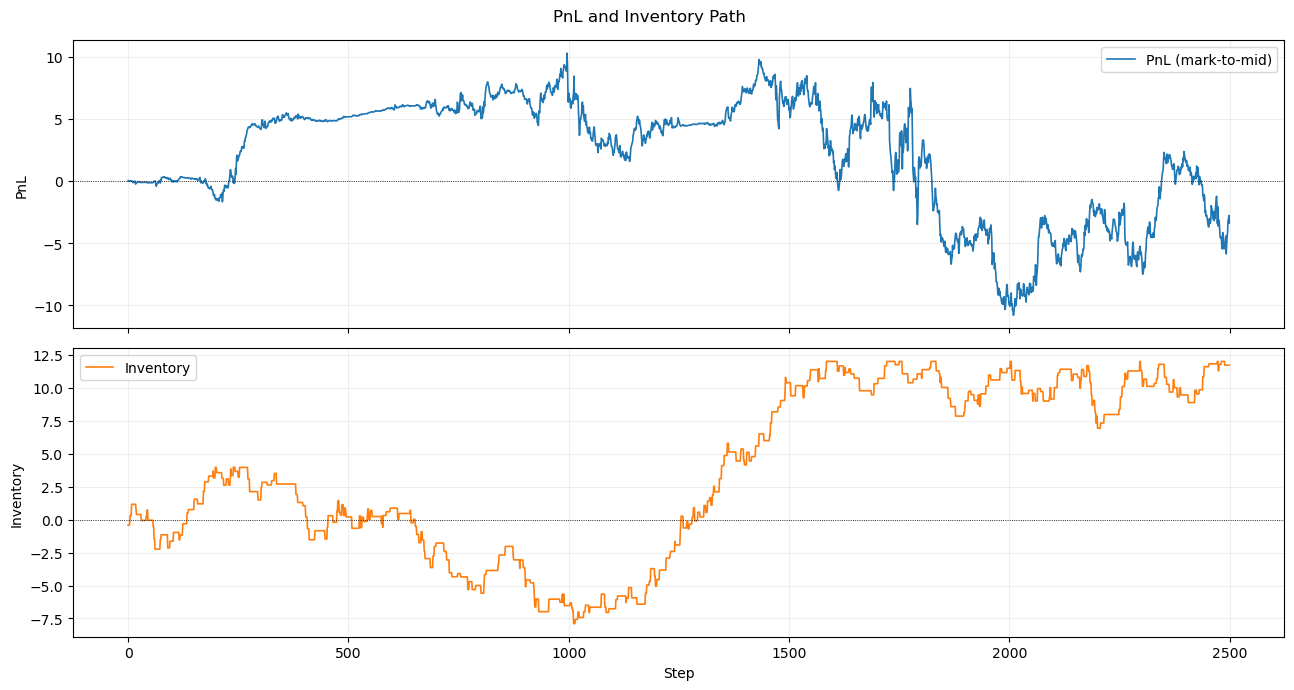

In [3]:
pnl       = series['pnl']
inventory = series['inventory']
mid       = series['mid']
spread    = series['spread']
steps     = list(range(len(pnl)))

fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

axes[0].plot(steps, pnl, label='PnL (mark-to-mid)', color='tab:blue', lw=1.2)
axes[0].axhline(0, color='black', lw=0.6, linestyle=':')
axes[0].set_ylabel('PnL')
axes[0].grid(alpha=0.2)
axes[0].legend()

axes[1].plot(steps, inventory, label='Inventory', color='tab:orange', lw=1.2)
axes[1].axhline(0, color='black', lw=0.6, linestyle=':')
axes[1].set_ylabel('Inventory')
axes[1].set_xlabel('Step')
axes[1].grid(alpha=0.2)
axes[1].legend()

fig.suptitle('PnL and Inventory Path')
plt.tight_layout()
plt.show()

## 2) Market state: mid price and vol-dependent spread

### How the synthetic market is generated

The mid price follows a **Geometric Brownian Motion (GBM)** process with Markov regime switching:

```
mid(t+1) = mid(t) × exp(drift_bps/10000 + σ(t) × Z),   Z ~ N(0,1)
```

where `σ(t)` switches between `sigma_bps` (calm) and `stressed_sigma_bps` (stressed) according to a two-state Markov chain with transition probabilities `calm_to_stressed_prob` and `stressed_to_calm_prob`.

### Vol-dependent spread widening

The quoted spread is not fixed — it widens during high-volatility steps:

```
spread(t) = spread_ticks × tick_size × (1 + spread_vol_sensitivity × |return(t)|/σ_calm)
```

This mimics real market-maker behaviour: when prices are moving fast, the cost of being adversely selected rises, so rational MMs widen their quotes. The scatter plot (spread vs. |return|) should show a clear positive slope proportional to `spread_vol_sensitivity`.

### What to look for

- **Regime clustering**: stressed periods appear as bursts of elevated spread and |return|. With `calm_to_stressed_prob=0.02` and `stressed_to_calm_prob=0.10`, expected stressed-regime duration is `1/0.10 = 10 steps`.
- **Flat scatter plot**: `spread_vol_sensitivity ≈ 0` — spread is effectively constant; not realistic.
- **Very wide spreads throughout**: `stressed_sigma_bps` may be too large or `calm_to_stressed_prob` too high.

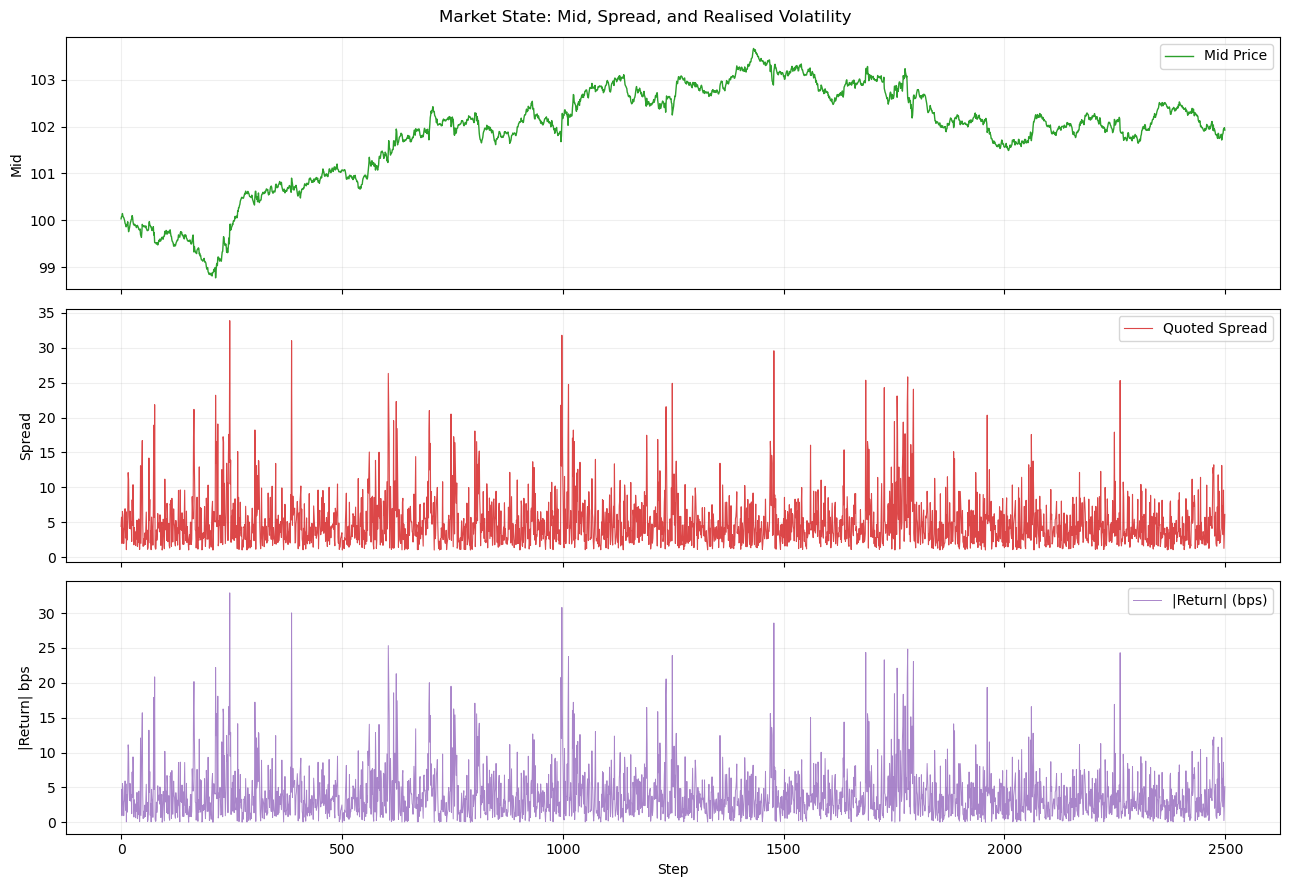

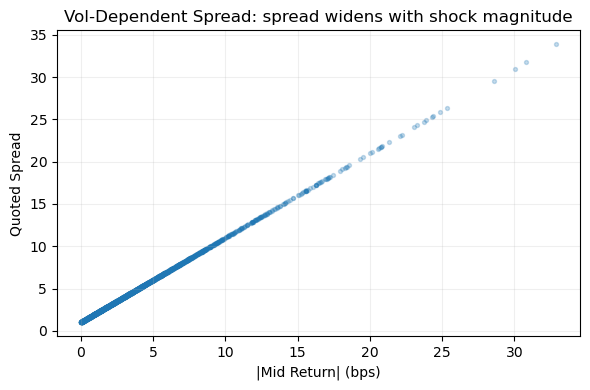

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(13, 9), sharex=True)

# Mid price
axes[0].plot(steps, mid, label='Mid Price', color='tab:green', lw=1.0)
axes[0].set_ylabel('Mid')
axes[0].grid(alpha=0.2)
axes[0].legend()

# Spread — shows vol-dependent widening
axes[1].plot(steps, spread, label='Quoted Spread', color='tab:red', lw=0.8, alpha=0.85)
axes[1].set_ylabel('Spread')
axes[1].grid(alpha=0.2)
axes[1].legend()

# Mid returns (step-to-step) — proxy for realised vol
mid_returns = [abs(mid[i] / mid[i-1] - 1.0) * 10_000.0 for i in range(1, len(mid))]
axes[2].plot(range(1, len(mid)), mid_returns, color='tab:purple', lw=0.7, alpha=0.8, label='|Return| (bps)')
axes[2].set_ylabel('|Return| bps')
axes[2].set_xlabel('Step')
axes[2].grid(alpha=0.2)
axes[2].legend()

fig.suptitle('Market State: Mid, Spread, and Realised Volatility')
plt.tight_layout()
plt.show()

# Scatter: spread vs |return| shows vol-spread relationship
fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.scatter(mid_returns, spread[1:], alpha=0.25, s=8, color='tab:blue')
ax2.set_xlabel('|Mid Return| (bps)')
ax2.set_ylabel('Quoted Spread')
ax2.set_title('Vol-Dependent Spread: spread widens with shock magnitude')
ax2.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## 3) Flow and side participation

### Why side balance matters for a market maker

A market maker ideally fills **symmetrically**: roughly equal buy-side and sell-side notional over time. When this holds, the strategy earns the bid-ask spread on a round-trip without accumulating directional exposure.

Asymmetric filling is a warning sign:
- **Predominantly buy fills**: the strategy is leaning long. Either order flow is directionally informed (adverse selection) or the inventory penalty is skewing quotes so far that only one side gets hit.
- **Predominantly sell fills**: the mirror situation.

### What the rolling fill count shows

The rolling window (default 50 steps) smooths the noisy per-step fill indicator into an activity rate. Look for:
- **Gradual long-run trend**: suggests the fill rate is consistent with `passive_fill_prob_base`.
- **Burst activity**: fills clustering around stressed periods (high vol) because of the vol-scaled aggressive cross probability — when markets are moving, more aggressive orders cross the spread and hit passive quotes.
- **Very sparse fills overall**: `half_spread_bps` may be too wide relative to `passive_fill_prob_base`.

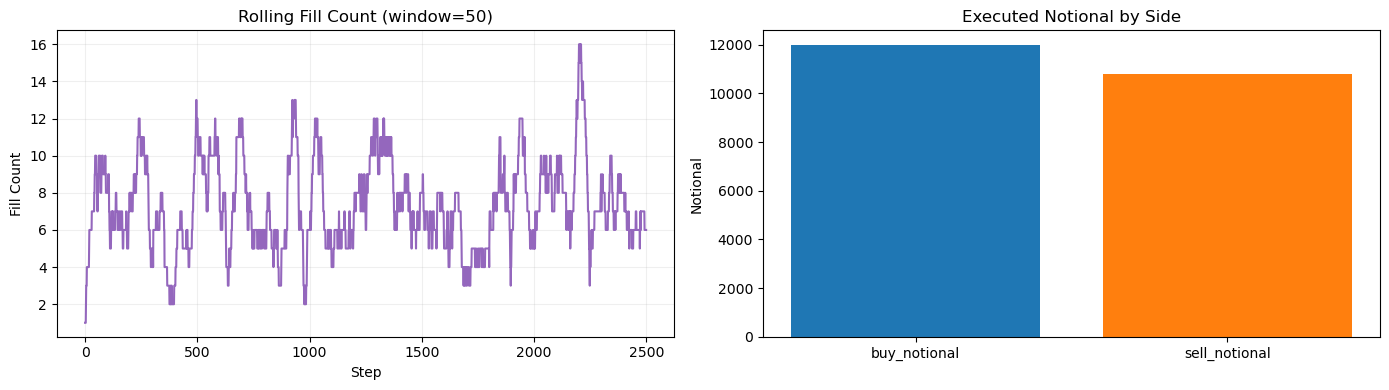

In [5]:
n_steps = len(series['pnl'])
fill_count = [0] * n_steps
buy_notional = 0.0
sell_notional = 0.0

for f in fills:
    step = f['step']
    if 0 <= step < n_steps:
        fill_count[step] += 1
    notional = f['price'] * f['size']
    if f['side'] == 'buy':
        buy_notional += notional
    else:
        sell_notional += notional

window = 50
rolling = []
for i in range(n_steps):
    lo = max(0, i - window + 1)
    rolling.append(sum(fill_count[lo:i+1]))

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(range(n_steps), rolling, color='tab:purple')
ax[0].set_title(f'Rolling Fill Count (window={window})')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Fill Count')
ax[0].grid(alpha=0.2)

ax[1].bar(['buy_notional', 'sell_notional'], [buy_notional, sell_notional], color=['tab:blue', 'tab:orange'])
ax[1].set_title('Executed Notional by Side')
ax[1].set_ylabel('Notional')

plt.tight_layout()
plt.show()

## Interpretation checklist {#interpretation-checklist}

Use this as a quick diagnostic guide after any parameter change.

---

### PnL & Inventory

| Symptom | Likely cause | Suggested fix |
|---------|-------------|---------------|
| PnL declining monotonically | Adverse selection dominates; informed flow | Widen `half_spread_bps` or increase `inv_penalty_bps` |
| Inventory grows without bound | Skew too weak to attract contra-side | Increase `inv_penalty_bps` |
| `inventory_half_life = inf` | Inventory never reverted to half-peak | As above — also check `max_inventory` cap isn't clamping |
| Very low `fill_rate` (< 0.02) | Quotes too wide; rarely get hit | Narrow `half_spread_bps` or raise `passive_fill_prob_base` |
| Very high `fill_rate` (> 0.4) | Quotes inside market; over-filling | Widen `half_spread_bps` |

---

### Spread dynamics

| Symptom | Likely cause | Suggested fix |
|---------|-------------|---------------|
| Flat scatter (spread vs. \|return\|) | `spread_vol_sensitivity = 0` | Raise `spread_vol_sensitivity` for realism |
| Permanently wide spreads | `stressed_sigma_bps` too large or always stressed | Lower `calm_to_stressed_prob` or reduce `stressed_sigma_bps` |
| No spread variation at all | Fixed-spread scenario | Expected if `spread_vol_sensitivity = 0` and single regime |

---

### Microstructure decomposition

The **spread decomposition identity** holds by construction:

```
Quoted half-spread = Realized half-spread + Adverse selection cost
```

| Metric | Healthy sign | Warning sign |
|--------|-------------|--------------|
| `realized_spread_avg > 0` | Earning from spread capture | Negative: paying more adverse selection than earning |
| `adverse_selection_avg` near zero | Uninformed flow dominates | Large negative: informed traders dominating fill mix |
| `adverse_selection_avg` positive | Beneficial flow (unusual) | Check horizon — may be too short to capture full impact |
| Quoted ≈ realized + adverse | Identity holds correctly | Large discrepancy: stale output JSON, re-run `make report` |

## 4) Microstructure metrics and spread decomposition

### The Glosten-Milgrom spread decomposition

In market microstructure theory (Glosten & Milgrom 1985), the quoted bid-ask spread compensates the market maker for two distinct costs:

1. **Adverse selection cost** — the expected loss from trading with an informed counterparty who knows more about the future price than you do. After a passive buy fill, if the mid subsequently falls, we were adversely selected: we bought at a price that is now above market.

2. **Realized (half-)spread** — what the market maker actually earns net of price impact. This is the portion of the quoted spread that is *not* eroded by adverse selection.

The identity is:

```
Quoted half-spread  =  Realized half-spread  +  Adverse selection cost
     (mid - bid)            (mid_after - bid)        (mid_before - mid_after)   [for a buy fill]
```

### How it is computed in this simulator

For each passive fill, the engine records:
- `mid_before`: mid at the time of the fill
- `mid_after`: mid exactly `adverse_selection_horizon` steps later

Then:
```python
adverse_selection_cost = mid_after - mid_before   # buy fill: did price rise against us?
realized_spread        = mid_after - fill_price   # buy fill: net half-spread captured
quoted_spread_half     = mid_before - fill_price  # buy fill: the half-spread we quoted
```

A **positive** `adverse_selection_cost` means the mid moved *with* us (beneficial). The typical sign for an adversely selected fill is **negative** (mid moved against us after we filled).

### Reading the bar chart

- **Green bar (realized spread) > 0**: we earned a positive net spread after accounting for price impact. Healthy.
- **Red bar (adverse selection cost)**: how much of our quoted spread was "stolen" by the mid moving against us. Smaller magnitude is better.
- If the red bar is larger than the green in absolute terms, the strategy is net negative on a per-fill basis — fee rebates and volume must compensate.

  Avg realized half-spread:    0.033989
  Avg adverse selection cost:  0.003553
  Fill rate (fills / step):    0.1476
  Inventory half-life (steps): inf  ← inventory never reverted to half-peak; consider raising inv_penalty_bps


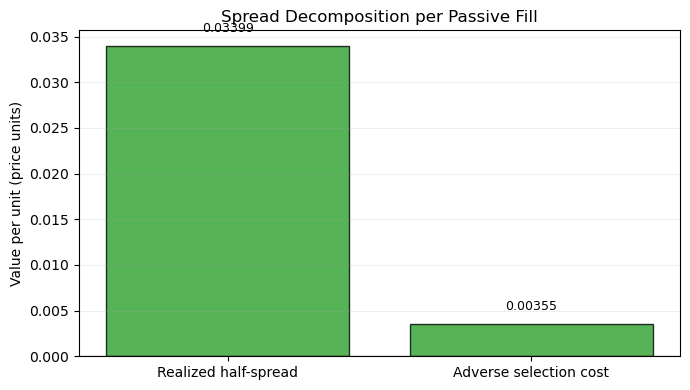

In [6]:
import math

rs  = summary.get('realized_spread_avg', None)
adv = summary.get('adverse_selection_avg', None)
hl  = summary.get('inventory_half_life', None)
fr  = summary.get('fill_rate', None)

print(f"  Avg realized half-spread:    {rs:.6f}"  if rs  is not None else "  realized_spread_avg: n/a (old output — run `make report`)")
print(f"  Avg adverse selection cost:  {adv:.6f}" if adv is not None else "  adverse_selection_avg: n/a (old output — run `make report`)")
print(f"  Fill rate (fills / step):    {fr:.4f}"  if fr  is not None else "  fill_rate: n/a")
if hl is None:
    print("  Inventory half-life (steps): n/a")
elif math.isinf(hl):
    print("  Inventory half-life (steps): inf  ← inventory never reverted to half-peak; consider raising inv_penalty_bps")
else:
    print(f"  Inventory half-life (steps): {hl:.0f}")

if rs is not None and adv is not None:
    labels = ['Realized half-spread', 'Adverse selection cost']
    values = [rs, adv]
    colors = ['tab:green' if v >= 0 else 'tab:red' for v in values]

    fig, ax = plt.subplots(figsize=(7, 4))
    bars = ax.bar(labels, values, color=colors, edgecolor='black', alpha=0.8)
    ax.axhline(0, color='black', lw=0.8)
    ax.set_ylabel('Value per unit (price units)')
    ax.set_title('Spread Decomposition per Passive Fill')
    ax.grid(axis='y', alpha=0.2)
    for bar, v in zip(bars, values):
        offset = abs(max(values) - min(values)) * 0.04
        ax.text(bar.get_x() + bar.get_width() / 2,
                v + (offset if v >= 0 else -offset),
                f'{v:.5f}', ha='center',
                va='bottom' if v >= 0 else 'top', fontsize=9)
    plt.tight_layout()
    plt.show()